<a href="https://colab.research.google.com/github/SheetalData/Secom-Assignment/blob/TongHere-Secom_patch-1/Boruta_KNN_1_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
# imputer
from sklearn.impute import SimpleImputer, KNNImputer


url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
names = ["feature" + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1,sep=" ", names=names, na_values = "NaN",header=None)
df1.head()

url2 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df2 = pd.read_csv(url2,sep=" ",names = ["Result","Date"])

#df2.columns =['Pass/Fail','Date']
df2.head()


,Result,Date
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [22]:
#Convertion of Date into Datetime from Object(String) data types
df2['Date'] = pd.to_datetime(df2['Date'])
df2.dtypes


#Joinig TWO df1 and df2 Dataframe naming SECOM
Secom = pd.concat([df1,df2],axis = 1)
print(Secom)

Secom = Secom.drop(['Date'],axis=1)
                   
# establish target and features of the manufacturing data
# set the target to the encoded manufacturing outcome column
y = Secom[['Result']]
# set the features as the rest of the dataset after dropping the features that are no
x = Secom.drop(['Result'], axis=1)

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)


      feature1  feature2   feature3   feature4  feature5  feature6  feature7  \
0      3030.93   2564.00  2187.7333  1411.1265    1.3602     100.0   97.6133   
1      3095.78   2465.14  2230.4222  1463.6606    0.8294     100.0  102.3433   
2      2932.61   2559.94  2186.4111  1698.0172    1.5102     100.0   95.4878   
3      2988.72   2479.90  2199.0333   909.7926    1.3204     100.0  104.2367   
4      3032.24   2502.87  2233.3667  1326.5200    1.5334     100.0  100.3967   
...        ...       ...        ...        ...       ...       ...       ...   
1562   2899.41   2464.36  2179.7333  3085.3781    1.4843     100.0   82.2467   
1563   3052.31   2522.55  2198.5667  1124.6595    0.8763     100.0   98.4689   
1564   2978.81   2379.78  2206.3000  1110.4967    0.8236     100.0   99.4122   
1565   2894.92   2532.01  2177.0333  1183.7287    1.5726     100.0   98.7978   
1566   2944.92   2450.76  2195.4444  2914.1792    1.5978     100.0   85.1011   

      feature8  feature9  feature10  ..

In [23]:
#Splitting data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1,stratify = y)


# getting the counts
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)


#Removing features having Missing ratio more than 50%


def percentna(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isnull().sum()/len(dataframe))>threshold]
    return columns.tolist()

 

na_columns = percentna(x_train, 0.5)
len(na_columns)
x_train_dn = x_train.drop(na_columns, axis=1)
x_train_dn.shape


shape of x_train:  (1096, 590)
shape of x_test:  (471, 590)
shape of y_train:  (1096, 1)
shape of y_test:  (471, 1)


(1096, 566)

In [24]:
#Low Variance Filter
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(x_train_dn)

 

constant_columns = [column for column in x_train_dn.columns
                    if column not in x_train_dn.columns[var_thres.get_support()]]


print(len(constant_columns))

x_train_lv = x_train_dn.drop(constant_columns,axis=1)

116


In [25]:
x_test_drop = x_test.copy()

x_test_drop = x_test_drop.drop(na_columns, axis=1)

x_test_drop = x_test_drop.drop(constant_columns,axis=1)

In [26]:
def outliers(feat):
 upper_limit = feat.mean() + 3*feat.std()
 lower_limit = feat.mean() - 3*feat.std()

 feat = np.where(
    feat >upper_limit,
    upper_limit,
    np.where(
       feat <lower_limit,
        lower_limit,
        feat ))
 return feat

x_train_outliers_imputation =x_train_lv.copy()
for column in x_train_outliers_imputation:
  x_train_outliers_imputation[column] = outliers(x_train_outliers_imputation[column])

In [31]:
numColumns = x_train_outliers_imputation.select_dtypes(include=np.number).columns.tolist();
# initialize imputer
imputer = KNNImputer()

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(x_train_outliers_imputation[numColumns])

# transform the data using the fitted imputer
X_train_knn_impute1 = imputer.transform(x_train_outliers_imputation[numColumns])
X_test_knn_impute1 = imputer.transform(x_test[numColumns])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute1 = pd.DataFrame(X_train_knn_impute1, columns=numColumns)
X_test_knn_impute1 = imputer.transform(x_test[numColumns])

In [33]:
pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.1 MB/s 


In [34]:
from boruta import BorutaPy

In [35]:
#BORUTA
#REFERENCE: https://github.com/bnsreenu/python_for_microscopists/blob/master/198_Boruta_feature_selection_breast_cancer.py
#pip install boruta
 
#Standarize train data for BORUTA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_std = sc.fit_transform(X_train_knn_impute1)
x_test_std = sc.transform(X_test_knn_impute1)
 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
 
# load y_train as an array
 
y = y_train.values
y = y.ravel()
 
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
 
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
 
# find all relevant features 
feat_selector.fit(x_train_std, y)
 
# check selected features 
feat_selector.support_
 
# check ranking of features
feat_selector.ranking_
#BORUTA
#REFERENCE: https://github.com/bnsreenu/python_for_microscopists/blob/master/198_Boruta_feature_selection_breast_cancer.py
#pip install boruta
 
#Standarize train data for BORUTA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_std = sc.fit_transform(X_train_knn_impute1)
x_test_std = sc.transform(X_test_knn_impute1)
 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
 
# load y_train as an array
 
y = y_train.values
y = y.ravel()
 
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
 
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
 
# find all relevant features 
feat_selector.fit(x_train_std, y)
 
# check selected features 
feat_selector.support_
 
# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	438
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	9
Rejected: 	438
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	8

array([  8, 366,  95, 117, 218, 132, 346,  49, 152, 211, 110, 223, 168,
       235,  30, 130, 415,   1, 420,   1, 172, 404, 207, 116, 321, 180,
         3, 311, 250,   6,  82,   1, 201,  20, 419,  51, 198, 194,  61,
        37, 204, 171, 241, 358, 325, 123, 389, 233, 297, 384, 157,  94,
       252,  31,   1, 354, 104, 208, 112,   9,  27, 292, 127, 170, 247,
       299,  86, 254, 438, 292,   2, 271,  84, 220, 278, 146, 347,  34,
       425, 227, 351, 330, 313,  10,  85, 166, 375, 429, 427, 225, 322,
       353, 372, 418, 167,   4, 332, 284, 381, 338, 387,  98, 314, 432,
        16, 181,  14, 208, 237, 107,   1,  48,  69,  20,  67,  11, 134,
       404,   6,   1, 286, 204,  12, 377, 149, 345, 147, 311,  62, 148,
       412,  72, 239, 181,  71,  76, 396, 301, 393,  40,  27, 306,  93,
       122, 130,  69,  53, 324,  91, 140, 315, 424, 356, 380, 234, 371,
       372, 137, 366, 161,  88, 358, 361,  58, 404,  52, 102, 274, 400,
       260, 125,  56, 257, 165, 239, 199, 231, 244, 360,  88, 11

Feature: feature1                       Rank: 8, Keep: False
Feature: feature2                       Rank: 366, Keep: False
Feature: feature3                       Rank: 95, Keep: False
Feature: feature4                       Rank: 117, Keep: False
Feature: feature5                       Rank: 218, Keep: False
Feature: feature6                       Rank: 132, Keep: False
Feature: feature7                       Rank: 346, Keep: False
Feature: feature8                       Rank: 49, Keep: False
Feature: feature9                       Rank: 152, Keep: False
Feature: feature10                      Rank: 211, Keep: False
Feature: feature11                      Rank: 110, Keep: False
Feature: feature12                      Rank: 223, Keep: False
Feature: feature13                      Rank: 168, Keep: False
Feature: feature14                      Rank: 235, Keep: False
Feature: feature15                      Rank: 30, Keep: False
Feature: feature16                      Rank: 130, Keep: Fal

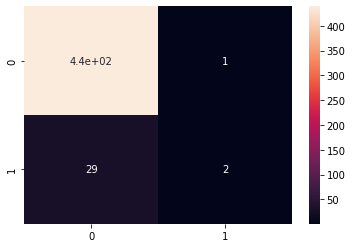

In [36]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(x_train_std)
 
import numpy as np
feature_names = np.array(Secom.columns)
 
# Ranked features greater than threshold
feature_ranks = list(zip(feature_names, 
 feat_selector.ranking_, 
 feat_selector.support_))
 
# print the results
for feat in feature_ranks:
 print('Feature: {:<30} Rank: {}, Keep: {}'.format(feat[0], feat[1], feat[2]))
 
#Now use the subset of features to fit XGBoost model on training data
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
 
xgb_model.fit(X_filtered, y_train)
 
#Now predict on test data using the trained model. 
 
#First apply feature selector transform to make sure same features are selected from test data
X_test_filtered = feat_selector.transform(x_test_std)
prediction_xgb = xgb_model.predict(X_test_filtered)
 
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_xgb))
 
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_xgb)
#print(cm)
sns.heatmap(cm, annot=True)